In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
# from Klein_Gordon_model_tf import Sampler, Klein_Gordon
import timeit
import os
os.environ["KMP_WARNINGS"] = "FALSE" 

import scipy
import scipy.io
import time


import sys

import scipy
import scipy.io
import time


import logging

import os.path
import shutil
from datetime import datetime
import pickle
def u(x):
    """
    :param x: x = (t, x)
    """
    return x[:, 1:2] * np.cos(5 * np.pi * x[:, 0:1]) + (x[:, 0:1] * x[:, 1:2])**3

def u_tt(x):
    return - 25 * np.pi**2 * x[:, 1:2] * np.cos(5 * np.pi * x[:, 0:1]) + 6 * x[:,0:1] * x[:,1:2]**3

def u_xx(x):
    return np.zeros((x.shape[0], 1)) +  6 * x[:,1:2] * x[:,0:1]**3

def f(x, alpha, beta, gamma, k):
    return u_tt(x) + alpha * u_xx(x) + beta * u(x) + gamma * u(x)**k

def operator(u, t, x, alpha, beta, gamma, k,  sigma_t=1.0, sigma_x=1.0):
    u_t = tf.gradients(u, t)[0] / sigma_t
    u_x = tf.gradients(u, x)[0] / sigma_x
    u_tt = tf.gradients(u_t, t)[0] / sigma_t
    u_xx = tf.gradients(u_x, x)[0] / sigma_x
    residual = u_tt + alpha * u_xx + beta * u + gamma * u**k
    return residual


In [2]:


class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

class Klein_Gordon:
    # Initialize the class
    def __init__(self, layers, operator, ics_sampler, bcs_sampler, res_sampler, alpha, beta, gamma, k, mode, sess):
            # mode = Klein_Gordon(layers, operator, ics_sampler, bcs_sampler, res_sampler, alpha, beta, gamma, k, mode, sess)



        self.mode = mode

        self.dirname, logpath = self.make_output_dir()
        self.logger = self.get_logger(logpath)     

        # Normalization constants
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_t, self.sigma_t = self.mu_X[0], self.sigma_X[0]
        self.mu_x, self.sigma_x = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.operator = operator
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        # Klein_Gordon constant
        self.alpha = tf.constant(alpha, dtype=tf.float32)
        self.beta = tf.constant(beta, dtype=tf.float32)
        self.gamma = tf.constant(gamma, dtype=tf.float32)
        self.k = tf.constant(k, dtype=tf.float32)


        # Record stiff ratio
        # self.stiff_ratio = stiff_ratio

        # Adaptive re-weighting constant
        self.rate = 0.9
        self.adaptive_constant_ics_val = np.array(1.0)
        self.adaptive_constant_bcs_val = np.array(1.0)
        self.adaptive_constant_res_val = np.array(1.0)

        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        # if model in ['M3', 'M4']:
        #     # Initialize encoder weights and biases
        #     self.encoder_weights_1 = self.xavier_init([2, layers[1]])
        #     self.encoder_biases_1 = self.xavier_init([1, layers[1]])

        #     self.encoder_weights_2 = self.xavier_init([2, layers[1]])
        #     self.encoder_biases_2 = self.xavier_init([1, layers[1]])

        # Define Tensorflow session
        self.sess = sess #tf.Session(config=tf.ConfigProto(log_device_placement=False))

        # Define placeholders and computational graph
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.r_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.adaptive_constant_ics_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_ics_val.shape)
        self.adaptive_constant_bcs_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_bcs_val.shape)
        self.adaptive_constant_res_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_res_val.shape)

        # Evaluate predictions
        self.u_ics_pred = self.net_u(self.t_ics_tf, self.x_ics_tf)
        self.u_t_ics_pred = self.net_u_t(self.t_ics_tf, self.x_ics_tf)
        self.u_bc1_pred = self.net_u(self.t_bc1_tf, self.x_bc1_tf)
        self.u_bc2_pred = self.net_u(self.t_bc2_tf, self.x_bc2_tf)

        self.u_pred = self.net_u(self.t_u_tf, self.x_u_tf)
        self.r_pred = self.net_r(self.t_r_tf, self.x_r_tf)

        # Boundary loss and Initial loss
        self.loss_ic_u = tf.reduce_mean(tf.square(self.u_ics_tf - self.u_ics_pred))
        self.loss_ic_u_t = tf.reduce_mean(tf.square(self.u_t_ics_pred))
        self.loss_bc1 = tf.reduce_mean(tf.square(self.u_bc1_pred - self.u_bc1_tf))
        self.loss_bc2 = tf.reduce_mean(tf.square(self.u_bc2_pred - self.u_bc2_tf))
        self.loss_res =  tf.reduce_mean(tf.square(self.r_pred - self.r_tf))

        self.loss_bcs =  (self.loss_bc1 + self.loss_bc2)
        self.loss_ics = (self.loss_ic_u + self.loss_ic_u_t)
        self.loss_u   =   self.loss_res 
        # Residual loss

        # Total loss
        self.loss =  self.adaptive_constant_res_tf *  self.loss_res + self.adaptive_constant_bcs_tf * (self.loss_bc1 + self.loss_bc2) +  self.adaptive_constant_ics_tf * (self.loss_ic_u + self.loss_ic_u_t)

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)


        self.loss_tensor_list = [self.loss ,  self.loss_res,  (self.loss_bc1 + self.loss_bc2) , ( self.loss_ic_u  + self.loss_ic_u_t ) ] 
        self.loss_list = ["total loss" , "loss_res" , "loss_bcs", "loss_ics"] 
        
        self.epoch_loss = dict.fromkeys(self.loss_list, 0)
        self.loss_history = dict((loss, []) for loss in self.loss_list)
        # Logger
        self.loss_u_log = []
        self.loss_r_log = []
        # self.saver = tf.train.Saver()

        # Generate dicts for gradients storage
        self.dict_gradients_res_layers = self.generate_grad_dict()
        self.dict_gradients_bcs_layers = self.generate_grad_dict()
        self.dict_gradients_ics_layers = self.generate_grad_dict()

        # Gradients Storage
        self.grad_res = []
        self.grad_ics = []
        self.grad_bcs = []

        for i in range(len(self.layers) - 1):
            self.grad_res.append(tf.gradients(self.loss_u, self.weights[i])[0])
            self.grad_bcs.append(tf.gradients(self.loss_bcs, self.weights[i])[0])
            self.grad_ics.append(tf.gradients(self.loss_ics, self.weights[i])[0])

        # Store the adaptive constant
  
        self.adaptive_constant_bcs_log = []
        self.adaptive_constant_ics_log = []
        self.adaptive_constant_res_log = []

        self.mean_adaptive_constant_res_log = []
        self.mean_adaptive_constant_bcs_log = []
        self.mean_adaptive_constant_ics_log = []
        # Compute the adaptive constant
        
        self.max_grad_res_list = []
        self.mean_grad_bcs_list = []
        self.mean_grad_ics_list = []

        for i in range(len(self.layers) - 1):
            self.max_grad_res_list.append(tf.reduce_mean(tf.abs(self.grad_res[i]))) 
            self.mean_grad_bcs_list.append(tf.reduce_mean(tf.abs(self.grad_bcs[i])))
            self.mean_grad_ics_list.append(tf.reduce_mean(tf.abs(self.grad_ics[i])))
        
        self.mean_grad_res = tf.reduce_mean(tf.stack(self.max_grad_res_list))
        self.mean_grad_bcs = tf.reduce_mean(tf.stack(self.mean_grad_bcs_list))
        self.mean_grad_ics = tf.reduce_mean(tf.stack(self.mean_grad_ics_list))
        
        self.adaptive_constant_bcs =self.mean_grad_bcs
        self.adaptive_constant_ics = self.mean_grad_ics
        self.adaptive_constant_res = self.mean_grad_res

        # # Stiff Ratio
        # if self.stiff_ratio:
        #     self.Hessian, self.Hessian_ics, self.Hessian_bcs, self.Hessian_res = self.get_H_op()
        #     self.eigenvalues, _ = tf.linalg.eigh(self.Hessian)
        #     self.eigenvalues_ics, _ = tf.linalg.eigh(self.Hessian_ics)
        #     self.eigenvalues_bcs, _ = tf.linalg.eigh(self.Hessian_bcs)
        #     self.eigenvalues_res, _ = tf.linalg.eigh(self.Hessian_res)

        #     self.eigenvalue_log = []
        #     self.eigenvalue_ics_log = []
        #     self.eigenvalue_bcs_log = []
        #     self.eigenvalue_res_log = []

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

################################################################################################################
                

    def lambda_balance(self  , term  ):
        histoy_mean =  np.mean(self.loss_history[term])
        m = 3 #len(self.loss_list)
        num = np.exp(  np.mean(self.loss_history[term][-99::]) )#/(self.T * histoy_mean)) np.exp( )
        denum = 0 
        loss_list = [ "loss_res" , "loss_bcs", "loss_ics"] 

        for  key in loss_list:
            denum +=  np.exp(   np.mean(self.loss_history[key][-99::]) )# /(self.T * histoy_mean))  np.exp(self.loss_history[key][-1] )
        return m * (num / denum)
    
    def trainmb(self, nIter=10000, batch_size=128):
        itValues = [1,100,1000,39999]

        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch boundary mini-batches
            X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size)
            X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
            X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)

            # Fetch residual mini-batch
            X_res_batch, f_res_batch = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                       self.u_ics_tf: u_ics_batch,
                       self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                       self.u_bc1_tf: u_bc1_batch,
                       self.t_bc2_tf: X_bc2_batch[:, 0:1], self.x_bc2_tf: X_bc2_batch[:, 1:2],
                       self.u_bc2_tf: u_bc2_batch,
                       self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2],
                       self.r_tf: f_res_batch,
                       self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val,
                       self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val,
                       self.adaptive_constant_res_tf: self.adaptive_constant_res_val
                       }

            # Run the Tensorflow session to minimize the loss
            _ , batch_losses = self.sess.run( [  self.train_op , self.loss_tensor_list ] ,tf_dict)
            self.assign_batch_losses(batch_losses)
            for key in self.loss_history:
                self.loss_history[key].append(self.epoch_loss[key])

            # Print
            if it % 1000 == 0:
                elapsed = timeit.default_timer() - start_time
                [loss ,  loss_res,  loss_bcs , loss_ics ]  = batch_losses


        # self.loss_tensor_list = [self.loss ,  self.loss_res,  (self.loss_bc1 + self.loss_bc2) , ( self.loss_ic_u  + self.loss_ic_u_t ) ] 
        # self.loss_list = ["total loss" , "loss_res" , "loss_bcs", "loss_ics"] 
        

                self.print('It: %d, Loss: %.3e, loss_bcs: %.3ee, loss_ics: %.3e, Loss_r: %.3e, Time: %.2f' %(it, loss, loss_bcs , loss_ics, loss_res, elapsed))

                # Compute and Print adaptive weights during training
                adaptive_constant_res_val, adaptive_constant_bcs_val, adaptive_constant_ics_val = self.sess.run( [self.adaptive_constant_res,
                                                                                                                                               self.adaptive_constant_bcs, 
                                                                                                                                               self.adaptive_constant_ics  ], tf_dict)
                min_grad = np.min( [adaptive_constant_res_val, adaptive_constant_bcs_val, adaptive_constant_ics_val])

                update_res = self.lambda_balance( "loss_res"  )
                update_ics_u = self.lambda_balance( "loss_ics"  )
                update_bcs = self.lambda_balance( "loss_bcs"  )
                
                self.adaptive_constant_res_val =  1.0 #(adaptive_constant_res_val /)* ( 1.0 - self.rate) + self.rate * self.adaptive_constant_res_val
                self.adaptive_constant_ics_val =  (adaptive_constant_res_val/adaptive_constant_ics_val) * ( 1.0 - self.rate) + self.rate * self.adaptive_constant_ics_val
                self.adaptive_constant_bcs_val =  (adaptive_constant_res_val/adaptive_constant_bcs_val) * ( 1.0 - self.rate) + self.rate * self.adaptive_constant_bcs_val

                self.print('min_grad: {:.3e}'.format( min_grad))

                
                self.print('update_res: {:.3e}'.format( update_res))
                self.print('update_ics_u_t: {:.3e}'.format( update_ics_u))
                self.print('update_bcs1: {:.3e}'.format( update_bcs))
            
                self.print('\nadaptive_constant_res_val: {:.3e}'.format( self.adaptive_constant_res_val))
                self.print('adaptive_constant_ics_val: {:.3e}'.format( self.adaptive_constant_ics_val))
                self.print('adaptive_constant_bcs1_val: {:.3e}'.format( self.adaptive_constant_bcs_val))
                
                self.adaptive_constant_res_log.append(self.adaptive_constant_res_val)
                self.adaptive_constant_bcs_log.append(self.adaptive_constant_bcs_val)
                self.adaptive_constant_ics_log.append(self.adaptive_constant_ics_val)

                mean_grad_res , mean_grad_bcs, mean_grad_ics = self.sess.run( [ self.mean_grad_res , self.mean_grad_bcs , self.mean_grad_ics  ], tf_dict)

                self.mean_adaptive_constant_res_log.append( mean_grad_res)
                self.mean_adaptive_constant_bcs_log.append( mean_grad_bcs)
                self.mean_adaptive_constant_ics_log.append( mean_grad_ics)


                self.print('\nmean_grad_res/mean_grad_bcs: {:.3e}'.format( mean_grad_res/mean_grad_bcs))
                self.print('mean_grad_res/mean_grad_ics: {:.3e}'.format( mean_grad_res/mean_grad_ics))
                self.print('\nmean_grad_bcs/mean_grad_ics: {:.3e}'.format( mean_grad_bcs/mean_grad_ics))

            start_time =  timeit.default_timer()
            if it in itValues:
                    self.plot_layerLoss(tf_dict , it)
                    self.print("Gradients information stored ...")

            sys.stdout.flush()

    # Create dictionary to store gradients
    def generate_grad_dict(self, layers):
        num = len(layers) - 1
        grad_dict = {}
        for i in range(num):
            grad_dict['layer_{}'.format(i + 1)] = []
        return grad_dict

    # Save gradients
    def save_gradients(self, tf_dict):
        num_layers = len(self.layers)
        for i in range(num_layers - 1):
            grad_ics_value , grad_bcs_value, grad_res_value= self.sess.run([self.grad_ics[i],
                                                                            self.grad_bcs[i],
                                                                            self.grad_res[i]],
                                                                            feed_dict=tf_dict)

            # save gradients of loss_res and loss_bcs
            self.dict_gradients_ics_layers['layer_' + str(i + 1)].append(grad_ics_value.flatten())
            self.dict_gradients_bcs_layers['layer_' + str(i + 1)].append(grad_bcs_value.flatten())
            self.dict_gradients_res_layers['layer_' + str(i + 1)].append(grad_res_value.flatten())
        return None

    # Compute the Hessian
    def flatten(self, vectors):
        return tf.concat([tf.reshape(v, [-1]) for v in vectors], axis=0)

    def get_Hv(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss, self.weights))
        vprod = tf.math.multiply(loss_gradients,
                                 tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weights))
        return Hv_op

    def get_Hv_ics(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_ics, self.weights))
        vprod = tf.math.multiply(loss_gradients,
                                 tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weights))
        return Hv_op

    def get_Hv_bcs(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_bcs, self.weights))
        vprod = tf.math.multiply(loss_gradients,
                                 tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weights))
        return Hv_op

    def get_Hv_res(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_res,
                                                   self.weights))
        vprod = tf.math.multiply(loss_gradients,
                                 tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod,
                                          self.weights))
        return Hv_op

    def get_H_op(self):
        self.P = self.flatten(self.weights).get_shape().as_list()[0]
        H = tf.map_fn(self.get_Hv, tf.eye(self.P, self.P),
                      dtype='float32')
        H_ics = tf.map_fn(self.get_Hv_ics, tf.eye(self.P, self.P),
                          dtype='float32')
        H_bcs = tf.map_fn(self.get_Hv_bcs, tf.eye(self.P, self.P),
                          dtype='float32')
        H_res = tf.map_fn(self.get_Hv_res, tf.eye(self.P, self.P),
                          dtype='float32')

        return H, H_ics, H_bcs, H_res

    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers)
        for l in range(0, num_layers - 2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    # if self.model in ['M3', 'M4']:
    #     num_layers = len(self.layers)
    #     encoder_1 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weights_1), self.encoder_biases_1))
    #     encoder_2 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weights_2), self.encoder_biases_2))

    #     for l in range(0, num_layers - 2):
    #         W = self.weights[l]
    #         b = self.biases[l]
    #         H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_1) + \
    #             tf.math.multiply(1 - tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_2)

    #     W = self.weights[-1]
    #     b = self.biases[-1]
    #     H = tf.add(tf.matmul(H, W), b)
    #     return H

    # Forward pass for u
    def net_u(self, t, x):
        u = self.forward_pass(tf.concat([t, x], 1))
        return u

    def net_u_t(self, t, x):
        u_t = tf.gradients(self.net_u(t, x), t)[0] / self.sigma_t
        return u_t

    # Forward pass for residual
    def net_r(self, t, x):
        u = self.net_u(t, x)
        residual = self.operator(u, t, x,  self.alpha, self.beta, self.gamma, self.k, self.sigma_t, self.sigma_x)
        return residual

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    # Trains the model by minimizing the MSE loss
################################################################################################################

    def train(self, nIter=10000):

        start_time = timeit.default_timer()
        batch_size = 500
        # Fetch boundary mini-batches
        X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size)
        X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
        X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)

        batch_size = 5000

        # Fetch residual mini-batch
        X_res_batch, f_res_batch = self.fetch_minibatch(self.res_sampler, batch_size)

        # Define a dictionary for associating placeholders with data
        tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                    self.u_ics_tf: u_ics_batch,
                    self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                    self.u_bc1_tf: u_bc1_batch,
                    self.t_bc2_tf: X_bc2_batch[:, 0:1], self.x_bc2_tf: X_bc2_batch[:, 1:2],
                    self.u_bc2_tf: u_bc2_batch,
                    self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2],
                    self.r_tf: f_res_batch,
                    self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val,
                    self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val}

        # Run the Tensorflow session to minimize the loss

        for it in range(nIter):
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_u_value, loss_r_value = self.sess.run([self.loss_u, self.loss_res], tf_dict)

                # Compute and Print adaptive weights during training
                # Compute the adaptive constant
                adaptive_constant_ics_val, adaptive_constant_bcs_val = self.sess.run( [self.adaptive_constant_ics, self.adaptive_constant_bcs], tf_dict)
                # Print adaptive weights during training
                self.adaptive_constant_ics_val = adaptive_constant_ics_val * ( 1.0 - self.rate) + self.rate * self.adaptive_constant_ics_val
                self.adaptive_constant_bcs_val = adaptive_constant_bcs_val * ( 1.0 - self.rate) + self.rate * self.adaptive_constant_bcs_val

                # # Store loss and adaptive weights
                # self.loss_u_log.append(loss_u_value)
                # self.loss_r_log.append(loss_r_value)

                # self.adaptive_constant_ics_log.append(self.adaptive_constant_ics_val)
                # self.adaptive_constant_bcs_log.append(self.adaptive_constant_bcs_val)
                if it % 1000 == 0:

                    print('It: %d, Loss: %.3e, Loss_u: %.3e, Loss_r: %.3e, Time: %.2f' %  (it, loss_value, loss_u_value, loss_r_value, elapsed))
                    print("constant_ics_val: {:.3f}, constant_bcs_val: {:.3f}".format(  self.adaptive_constant_ics_val,  self.adaptive_constant_bcs_val))
                start_time = timeit.default_timer()

            # # Compute the eigenvalues of the Hessian of losses
            # if self.stiff_ratio:
            #     if it % 1000 == 0:
            #         print("Eigenvalues information stored ...")
            #         eigenvalues, eigenvalues_ics, eigenvalues_bcs, eigenvalues_res = self.sess.run([self.eigenvalues,
            #                                                                                         self.eigenvalues_ics,
            #                                                                                         self.eigenvalues_bcs,
            #                                                                                         self.eigenvalues_res], tf_dict)
            #         self.eigenvalue_log.append(eigenvalues)
            #         self.eigenvalue_ics_log.append(eigenvalues_bcs)
            #         self.eigenvalue_bcs_log.append(eigenvalues_bcs)
            #         self.eigenvalue_res_log.append(eigenvalues_res)

            # # Store gradients
            # if it % 10000 == 0:
            #     self.save_gradients(tf_dict)
            #     print("Gradients information stored ...")



    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_u_tf: X_star[:, 0:1], self.x_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_r_tf: X_star[:, 0:1], self.x_r_tf: X_star[:, 1:2]}
        r_star = self.sess.run(self.r_pred, tf_dict)
        return r_star

  # ###############################################################################################################################################
   # 
   #  
    def plot_layerLoss(self , tf_dict , epoch):
        ## Gradients #
        num_layers = len(self.layers)
        for i in range(num_layers - 1):
            grad_res, grad_bc1  , grad_ics  = self.sess.run([ self.grad_res[i],self.grad_bcs[i],self.grad_ics[i]], feed_dict=tf_dict)

            # save gradients of loss_r and loss_u
            self.dict_gradients_res_layers['layer_' + str(i + 1)].append(grad_res.flatten())
            self.dict_gradients_bcs_layers['layer_' + str(i + 1)].append(grad_bc1.flatten())
            self.dict_gradients_ics_layers['layer_' + str(i + 1)].append(grad_ics.flatten())

        num_hidden_layers = num_layers -1
        cnt = 1
        fig = plt.figure(4, figsize=(13, 4))
        for j in range(num_hidden_layers):
            ax = plt.subplot(1, num_hidden_layers, cnt)
            ax.set_title('Layer {}'.format(j + 1))
            ax.set_yscale('symlog')
            gradients_res = self.dict_gradients_res_layers['layer_' + str(j + 1)][-1]
            gradients_bc1 = self.dict_gradients_bcs_layers['layer_' + str(j + 1)][-1]
            gradients_ics = self.dict_gradients_ics_layers['layer_' + str(j + 1)][-1]

            sns.distplot(gradients_res, hist=False,kde_kws={"shade": False},norm_hist=True,  label=r'$\nabla_\theta \mathcal{L}_r$')

            sns.distplot(gradients_bc1, hist=False,kde_kws={"shade": False},norm_hist=True,   label=r'$\nabla_\theta \mathcal{L}_{u_{bc1}}$')
            sns.distplot(gradients_ics, hist=False,kde_kws={"shade": False},norm_hist=True,   label=r'$\nabla_\theta \mathcal{L}_{u_{ics}}$')

            #ax.get_legend().remove()
            ax.set_xlim([-1.0, 1.0])
            #ax.set_ylim([0, 150])
            cnt += 1
        handles, labels = ax.get_legend_handles_labels()

        fig.legend(handles, labels, loc="center",  bbox_to_anchor=(0.5, -0.03),borderaxespad=0,bbox_transform=fig.transFigure, ncol=3)
        text = 'layerLoss_epoch' + str(epoch) +'.png'
        plt.savefig(os.path.join(self.dirname,text) , bbox_inches='tight')
        plt.close("all" , )
    # #########################
    # def make_output_dir(self):
        
    #     if not os.path.exists("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints"):
    #         os.mkdir("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints")
    #     dirname = os.path.join("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints", datetime.now().strftime("%b-%d-%Y_%H-%M-%S-%f_") + self.mode)
    #     os.mkdir(dirname)
    #     text = 'output.log'
    #     logpath = os.path.join(dirname, text)
    #     shutil.copyfile('/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/M2.py', os.path.join(dirname, 'M2.py'))

    #     return dirname, logpath
    
    # # ###########################################################
    def make_output_dir(self):
        
        if not os.path.exists("checkpoints"):
            os.mkdir("checkpoints")
        dirname = os.path.join("checkpoints", datetime.now().strftime("%b-%d-%Y_%H-%M-%S-%f_") + self.mode)
        os.mkdir(dirname)
        text = 'output.log'
        logpath = os.path.join(dirname, text)
        shutil.copyfile('M2.ipynb', os.path.join(dirname, 'M2.ipynb'))
        return dirname, logpath
    

    def get_logger(self, logpath):
        logger = logging.getLogger(__name__)
        logger.setLevel(logging.DEBUG)
        sh = logging.StreamHandler()
        sh.setLevel(logging.DEBUG)        
        sh.setFormatter(logging.Formatter('%(message)s'))
        fh = logging.FileHandler(logpath)
        logger.addHandler(sh)
        logger.addHandler(fh)
        return logger


   
    def print(self, *args):
        for word in args:
            if len(args) == 1:
                self.logger.info(word)
            elif word != args[-1]:
                for handler in self.logger.handlers:
                    handler.terminator = ""
                if type(word) == float or type(word) == np.float64 or type(word) == np.float32: 
                    self.logger.info("%.4e" % (word))
                else:
                    self.logger.info(word)
            else:
                for handler in self.logger.handlers:
                    handler.terminator = "\n"
                if type(word) == float or type(word) == np.float64 or type(word) == np.float32:
                    self.logger.info("%.4e" % (word))
                else:
                    self.logger.info(word)


    def plot_loss_history(self , path):

        fig, ax = plt.subplots()
        fig.set_size_inches([15,8])
        for key in self.loss_history:
            self.print("Final loss %s: %e" % (key, self.loss_history[key][-1]))
            ax.semilogy(self.loss_history[key], label=key)
        ax.set_xlabel("epochs", fontsize=15)
        ax.set_ylabel("loss", fontsize=15)
        ax.tick_params(labelsize=15)
        ax.legend()
        plt.savefig(path)
        plt.close("all" , )
       #######################
    def save_NN(self):

        uv_weights = self.sess.run(self.weights)
        uv_biases = self.sess.run(self.biases)

        with open(os.path.join(self.dirname,'model.pickle'), 'wb') as f:
            pickle.dump([uv_weights, uv_biases], f)
            self.print("Save uv NN parameters successfully in %s ..." , self.dirname)

        # with open(os.path.join(self.dirname,'loss_history_BFS.pickle'), 'wb') as f:
        #     pickle.dump(self.loss_rec, f)
        with open(os.path.join(self.dirname,'loss_history_BFS.png'), 'wb') as f:
            self.plot_loss_history(f)


    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values


    def generate_grad_dict(self):
        num = len(self.layers) - 1
        grad_dict = {}
        for i in range(num):
            grad_dict['layer_{}'.format(i + 1)] = []
        return grad_dict
    
    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values
            
    def plt_prediction(self , x1 , x2 , X_star , u_star , u_pred , f_star , f_pred):
        from mpl_toolkits.axes_grid1 import ImageGrid

        ### Plot ###
        plt.close("all" , )

        # Exact solution & Predicted solution
        # Exact soluton
        U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
        F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')

        # Predicted solution
        U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
        F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

        titles = ['Exact $u(x)$' , 'Predicted $u(x)$' , 'Absolute error' , 'Exact $f(x)$' , 'Predicted $f(x)$' , 'Absolute error']
        data = [U_star , U_pred ,  np.abs(U_star - U_pred) , F_star , F_pred ,  np.abs(F_star - F_pred) ]
        

        fig_1 = plt.figure(1, figsize=(13, 5))
        grid = ImageGrid(fig_1, 111, direction="row", nrows_ncols=(2,3), 
                        label_mode="1", axes_pad=1.7, share_all=False, 
                        cbar_mode="each", cbar_location="right", 
                        cbar_size="5%", cbar_pad=0.0)
    # CREATE ARGUMENTS DICT FOR CONTOURPLOTS
        minmax_list = []
        kwargs_list = []
        for d in data:
            # if(local):
            #     minmax_list.append([np.min(d), np.max(d)])
            # else:
            minmax_list.append([np.min(d), np.max(d)])

            kwargs_list.append(dict(levels=np.linspace(minmax_list[-1][0],minmax_list[-1][1], 60),
                cmap="coolwarm", vmin=minmax_list[-1][0], vmax=minmax_list[-1][1]))

        for ax, z, kwargs, minmax, title in zip(grid, data, kwargs_list, minmax_list, titles):
        #pcf = [ax.tricontourf(x, y, z[0,:], **kwargs)]
            #pcfsets.append(pcf)
            # if (timeStp == 0):
                #  print( z[timeStp,:,:])
            pcf = [ax.pcolor(x1, x2, z , cmap='jet')]
            cb = ax.cax.colorbar(pcf[0], ticks=np.linspace(minmax[0],minmax[1],7),  format='%.3e')
            ax.cax.tick_params(labelsize=14.5)
            ax.set_title(title, fontsize=14.5, pad=7)
            ax.set_ylabel("time", labelpad=14.5, fontsize=14.5, rotation="horizontal")
            ax.set_xlabel("x", fontsize=14.5)
            ax.tick_params(labelsize=14.5)
            ax.set_xlim(x1.min(), x1.max())
            ax.set_ylim(x2.min(), x2.max())
            ax.set_aspect("equal")

        fig_1.set_size_inches(15, 10, True)
        fig_1.subplots_adjust(left=0.7, bottom=0, right=2.2, top=0.5, wspace=None, hspace=None)
        plt.tight_layout()
        plt.savefig(os.path.join(self.dirname,"prediction.png"), dpi=300 , bbox_inches='tight')
        plt.close("all" , )


    def plot_grad(self ):

        fig, ax = plt.subplots()
        fig.set_size_inches([15,8])
        ax.semilogy(self.adaptive_constant_bcs_log, label=r'$\bar{\nabla_\theta \mathcal{L}_{u_{bc}}}$')
        ax.semilogy(self.adaptive_constant_ics_log, label=r'$\bar{\nabla_\theta \mathcal{L}_{u_{ic}}}$')
        ax.set_xlabel("epochs", fontsize=15)
        ax.set_ylabel("loss", fontsize=15)
        ax.tick_params(labelsize=15)
        ax.legend()
        path = os.path.join(self.dirname,'grad_history.png')
        plt.savefig(path)
        plt.close("all" , )



  
    
    def plot_lambda(self ):

        fontsize = 17
        fig, ax = plt.subplots()
        fig.set_size_inches([16,8])
        ax.semilogy(self.mean_adaptive_constant_bcs_log, label=r'$\bar{\nabla_\theta {u_{bc}}}$' , color = 'tab:green')
        ax.semilogy(self.mean_adaptive_constant_ics_log, label=r'$\bar{\nabla_\theta {u_{ics}}}$' , color = 'tab:blue')
        ax.semilogy(self.mean_adaptive_constant_res_log, label=r'$Max{\nabla_\theta {u_{phy}}}$' , color = 'tab:red')
        ax.set_xlabel("epochs", fontsize=fontsize)
        ax.set_ylabel(r'$\bar{\nabla_\theta {u}}$', fontsize=fontsize)
        ax.tick_params(labelsize=fontsize)
        ax.legend(loc='center left', bbox_to_anchor=(-0.25, 0.5))

        ax2 = ax.twinx() 

        # fig, ax = plt.subplots()
        # fig.set_size_inches([15,8])
    
        ax2.semilogy(self.adaptive_constant_bcs_log, label=r'$\bar{\lambda_{bc}}$'  ,  linestyle='dashed' , color = 'tab:green') 
        ax2.semilogy(self.adaptive_constant_ics_log, label=r'$\bar{\lambda_{ics}}$' , linestyle='dashed'  , color = 'tab:blue')
        ax2.semilogy(self.adaptive_constant_res_log, label=r'$\bar{\lambda_{phy}}$' ,  linestyle='dashed' , color = 'tab:red')
        ax2.set_xlabel("epochs", fontsize=fontsize)
        ax2.set_ylabel(r'$\bar{\lambda}$', fontsize=fontsize)
        ax2.tick_params(labelsize=fontsize)
        ax2.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))

        plt.tight_layout()

        path = os.path.join(self.dirname,'lambda_history.png')
        plt.savefig(path)



In [3]:
def test_method(method , layers, operator, ics_sampler, bcs_sampler, res_sampler, alpha, beta, gamma ,k ,mode , stiff_ratio ,  X_star , u_star , f_star):


    model = Klein_Gordon(layers, operator, ics_sampler, bcs_sampler, res_sampler, alpha, beta, gamma, k, mode, stiff_ratio)

    # Train model
    start_time = time.time()

    if method =="full_batch":
        model.train(nIter=40001 )
    elif method =="mini_batch":
        model.trainmb(nIter=40001, batch_size=128)
    else:
        print("unknown method!")
    elapsed = time.time() - start_time

    # Predictions
    u_pred = model.predict_u(X_star)
    f_pred = model.predict_r(X_star)

    # Relative error
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    print('Relative L2 error_f: {:.2e}'.format(error_f))

    return [elapsed, error_u , error_f]



In [4]:

# Parameters of equations
alpha = -1.0
beta = 0.0
gamma = 1.0
k = 3
# Domain boundaries
ics_coords = np.array([[0.0, 0.0], [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0], [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0], [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]])


# Define model
layers = [2, 50, 50, 50, 50, 50, 1]
mode = 'M2'          # Method: 'M1', 'M2', 'M3', 'M4'
stiff_ratio = False  # Log the eigenvalues of Hessian of losses



nIter =40001
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 128

# Test data
nn = 100
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

# Exact solution
u_star = u(X_star)
f_star = f(X_star, alpha, beta, gamma, k)


iterations = 1
methods = ["mini_batch" ]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    error_f_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create initial conditions samplers
        ics_sampler = Sampler(2, ics_coords, lambda x: u(x), name='Initial Condition 1')

        # Create boundary conditions samplers
        bc1 = Sampler(2, bc1_coords, lambda x: u(x), name='Dirichlet BC1')
        bc2 = Sampler(2, bc2_coords, lambda x: u(x), name='Dirichlet BC2')
        bcs_sampler = [bc1, bc2]

        # Create residual sampler
        res_sampler = Sampler(2, dom_coords, lambda x: f(x, alpha, beta, gamma, k), name='Forcing')
        bcs_sampler = [bc1, bc2]

        # [elapsed, error_u , error_f] = test_method(mtd , layers, operator, ics_sampler, bcs_sampler, res_sampler, alpha, beta, gamma ,k ,mode , stiff_ratio ,  X_star , u_star , f_star)

        tf.reset_default_graph()
        gpu_options = tf.GPUOptions(visible_device_list="0")
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:

            model = Klein_Gordon(layers, operator, ics_sampler, bcs_sampler, res_sampler, alpha, beta, gamma, k, mode, sess)

            # Train model
            start_time = time.time()

            if mtd =="full_batch":
                model.train(nIter=nIter )
            elif mtd =="mini_batch":
                model.trainmb(nIter=nIter, batch_size=128)
            else:
                print("unknown method!")
            elapsed = time.time() - start_time

            # Predictions
            u_pred = model.predict_u(X_star)
            f_pred = model.predict_r(X_star)

            # Relative error
            error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
            error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

            model.print('Relative L2 error_u: {:.2e}'.format(error_u))
            model.print('Relative L2 error_f: {:.2e}'.format(error_f))
            
            model.print("average lambda_bc" , np.average(model.adaptive_constant_bcs_log))
            model.print("average lambda_bc" , np.average(model.adaptive_constant_ics_log))
            model.print("average lambda_res" , str(1.0))
            # sess.close()  
            model.plot_lambda()
            model.plot_grad()
            model.save_NN()
            model.plt_prediction( t , x , X_star , u_star , u_pred , f_star , f_pred)

            time_list.append(elapsed)
            error_u_list.append(error_u)
            error_f_list.append(error_f)

    # print("\n\nMethod: ", mtd)
    model.print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    model.print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    model.print("average of error_f_list:" , sum(error_f_list) / len(error_f_list) )

    result_dict[mtd] = [time_list ,error_u_list ,  error_f_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat(os.path.join(model.dirname,""+mtd+"_Helmholtz_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_exp"+str(bcbatch_size)+"nIter"+str(nIter)+".mat") , result_dict)




Method:  mini_batch
Epoch:  1








2023-12-28 06:24:28.925759: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 06:24:28.949417: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2023-12-28 06:24:28.949888: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d85c1fcaa0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-28 06:24:28.949906: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-28 06:24:28.950346: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



It: 0, Loss: 8.963e+03, loss_bcs: 1.354e+00e, loss_ics: 5.510e-01, Loss_r: 8.961e+03, Time: 2.65
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/ipykernel_launcher.py:200: RuntimeWarning: overflow encountered in exp
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/ipykernel_launcher.py:205: RuntimeWarning: overflow encountered in exp
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in true_divide
min_grad: 9.357e-02
update_res: nan
update_ics_u_t: 0.000e+00
update_bcs1: 0.000e+00

adaptive_constant_res_val: 1.000e+00
adaptive_constant_ics_val: 2.704e+00
adaptive_constant_bcs1_val: 2.773e+00

mean_grad_res/mean_grad_bcs: 1.873e+01
mean_grad_res/mean_grad_ics: 1.804e+01

mean_grad_bcs/mean_grad_ics: 9.633e-01
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be remove

Relative L2 error_u: 7.02e-03
Relative L2 error_f: 3.59e-03


Save uv NN parameters successfully in %s ...checkpoints/Dec-28-2023_06-24-28-950737_M2
Final loss total loss: 7.412288e-02
Final loss loss_res: 5.722688e-02
Final loss loss_bcs: 8.041303e-07
Final loss loss_ics: 6.021377e-05



average of time_list: 633.0268633365631
average of error_u_list: 0.007024857082828903
average of error_f_list: 0.0035920475139617344


In [ ]:
model.loss_history["loss_ics"][-1]

0.0722954

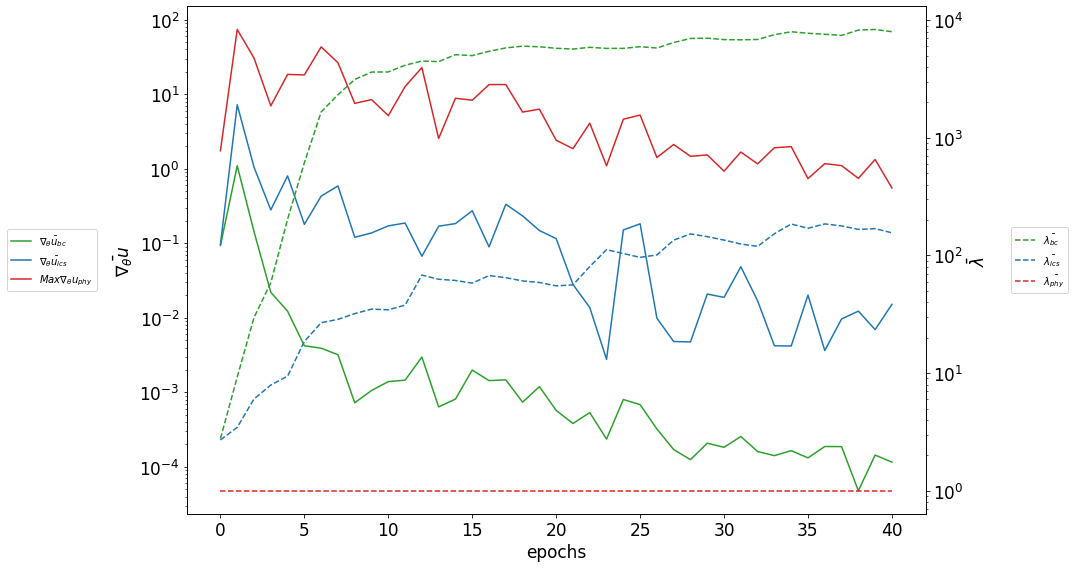

In [5]:
model.plot_lambda()

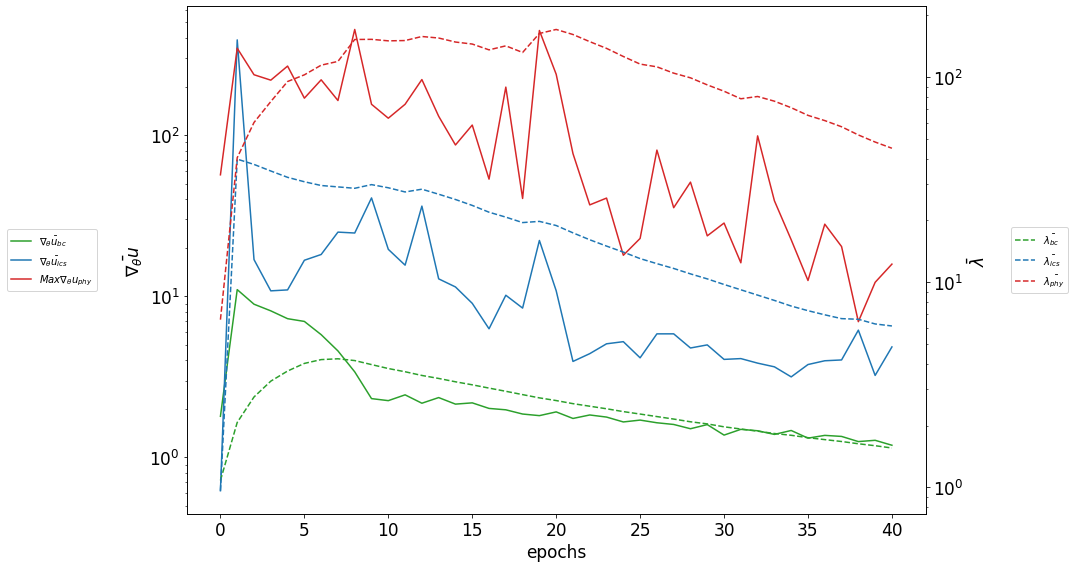

In [5]:
model.plot_lambda()

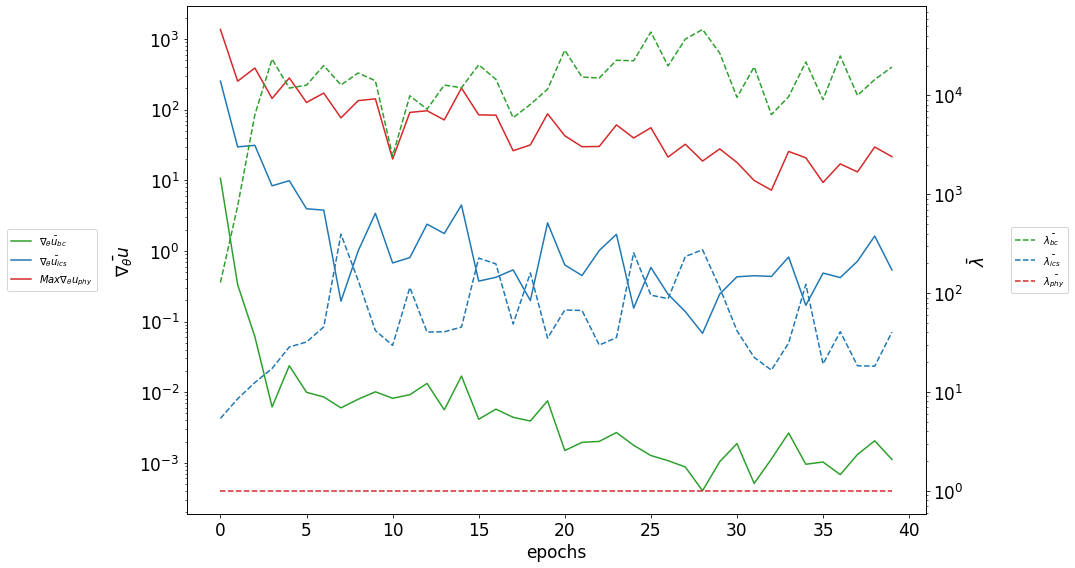

In [5]:

    
    
def plot_lambda(self ):

        fontsize = 17
        fig, ax = plt.subplots()
        fig.set_size_inches([16,8])
        ax.semilogy(self.mean_adaptive_constant_bcs_log, label=r'$\bar{\nabla_\theta {u_{bc}}}$' , color = 'tab:green')
        ax.semilogy(self.mean_adaptive_constant_ics_log, label=r'$\bar{\nabla_\theta {u_{ics}}}$' , color = 'tab:blue')
        ax.semilogy(self.mean_adaptive_constant_res_log, label=r'$Max{\nabla_\theta {u_{phy}}}$' , color = 'tab:red')
        ax.set_xlabel("epochs", fontsize=fontsize)
        ax.set_ylabel(r'$\bar{\nabla_\theta {u}}$', fontsize=fontsize)
        ax.tick_params(labelsize=fontsize)
        ax.legend(loc='center left', bbox_to_anchor=(-0.25, 0.5))

        ax2 = ax.twinx() 

        # fig, ax = plt.subplots()
        # fig.set_size_inches([15,8])
    
        ax2.semilogy(self.adaptive_constant_bcs_log, label=r'$\bar{\lambda_{bc}}$'  ,  linestyle='dashed' , color = 'tab:green') 
        ax2.semilogy(self.adaptive_constant_ics_log, label=r'$\bar{\lambda_{ics}}$' , linestyle='dashed'  , color = 'tab:blue')
        ax2.semilogy(self.adaptive_constant_res_log, label=r'$\bar{\lambda_{phy}}$' ,  linestyle='dashed' , color = 'tab:red')
        ax2.set_xlabel("epochs", fontsize=fontsize)
        ax2.set_ylabel(r'$\bar{\lambda}$', fontsize=fontsize)
        ax2.tick_params(labelsize=fontsize)
        ax2.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))

        plt.tight_layout()

        path = os.path.join(self.dirname,'lambda_history.png')
        plt.savefig(path)

plot_lambda(model)

In [5]:
def plt_prediction(self , x1 , x2 , X_star , u_star , u_pred , f_star , f_pred):
    from mpl_toolkits.axes_grid1 import ImageGrid

    ### Plot ###
    print(x1.shape)
    print(x2.shape)

    # Exact solution & Predicted solution
    # Exact soluton
    U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
    F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')
    print(u_star.shape)

    # Predicted solution
    U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
    F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

    titles = ['Exact $u(x)$' , 'Predicted $u(x)$' , 'Absolute error' , 'Exact $f(x)$' , 'Predicted $f(x)$' , 'Absolute error']
    data = [U_star , U_pred ,  np.abs(U_star - U_pred) , F_star , F_pred ,  np.abs(F_star - F_pred) ]
    
    print(U_star.shape)

    fig_1 = plt.figure(1, figsize=(13, 5))
    grid = ImageGrid(fig_1, 111, direction="row", nrows_ncols=(2,3), 
                    label_mode="1", axes_pad=1.7, share_all=False, 
                    cbar_mode="each", cbar_location="right", 
                    cbar_size="5%", cbar_pad=0.0)
# CREATE ARGUMENTS DICT FOR CONTOURPLOTS
    minmax_list = []
    kwargs_list = []
    for d in data:
        # if(local):
        #     minmax_list.append([np.min(d), np.max(d)])
        # else:
        minmax_list.append([np.min(d), np.max(d)])

        kwargs_list.append(dict(levels=np.linspace(minmax_list[-1][0],minmax_list[-1][1], 60),
            cmap="coolwarm", vmin=minmax_list[-1][0], vmax=minmax_list[-1][1]))

    for ax, z, kwargs, minmax, title in zip(grid, data, kwargs_list, minmax_list, titles):
    #pcf = [ax.tricontourf(x, y, z[0,:], **kwargs)]
        #pcfsets.append(pcf)
        # if (timeStp == 0):
            #  print( z[timeStp,:,:])
        pcf = [ax.pcolor(x1, x2, z , cmap='jet')]
        print(z.shape)
        cb = ax.cax.colorbar(pcf[0], ticks=np.linspace(minmax[0],minmax[1],7),  format='%.3e')
        ax.cax.tick_params(labelsize=14.5)
        ax.set_title(title, fontsize=14.5, pad=7)
        ax.set_ylabel("time", labelpad=14.5, fontsize=14.5, rotation="horizontal")
        ax.set_xlabel("x", fontsize=14.5)
        ax.tick_params(labelsize=14.5)
        ax.set_xlim(x1.min(), x1.max())
        ax.set_ylim(x2.min(), x2.max())
        ax.set_aspect("equal")

    fig_1.set_size_inches(15, 10, True)
    fig_1.subplots_adjust(left=0.7, bottom=0, right=2.2, top=0.5, wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig(os.path.join(self.dirname,"prediction.png"), dpi=300 , bbox_inches='tight')
    plt.close("all" , )



In [23]:
plt_prediction(model, t , x , X_star , u_star , u_pred , f_star , f_pred)


(100, 100)
(100, 100)


(10000, 1)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


In [17]:
X_star.shape

(10000, 2)

In [ ]:


# Test data
nn = 100
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

# Exact solution
u_star = u(X_star)
f_star = f(X_star, alpha, beta, gamma, k)

# Predictions
u_pred = mode.predict_u(X_star)
f_pred = mode.predict_r(X_star)

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print('Relative L2 error_u: {:.2e}'.format(error_u))

### Plot ###

# Test data
U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
F_star = griddata(X_star, f_star.flatten(), (t, x), method='cubic')

U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
F_pred = griddata(X_star, f_pred.flatten(), (t, x), method='cubic')

fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact u(x)')

plt.subplot(1, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(x)')

plt.subplot(1, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()


fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(t, x, F_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact u(x)')

plt.subplot(1, 3, 2)
plt.pcolor(t, x, F_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(x)')

plt.subplot(1, 3, 3)
plt.pcolor(t, x, np.abs(F_star - F_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

In [ ]:

# Loss
loss_r = mode.loss_r_log
loss_u = mode.loss_u_log

fig_2 = plt.figure(2)
ax = fig_2.add_subplot(1, 1, 1)
ax.plot(loss_r, label='$\mathcal{L}_{r}$')
ax.plot(loss_u, label='$\mathcal{L}_{u}$')
ax.set_yscale('log')
ax.set_xlabel('iterations')
ax.set_ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

# Adaptive Constant
adaptive_constant_ics = mode.adaptive_constant_ics_log
adaptive_constant_bcs = mode.adaptive_constant_bcs_log

fig_3 = plt.figure(3)
ax = fig_3.add_subplot(1, 1, 1)
ax.plot(adaptive_constant_ics, label='$\lambda_{u_0}$')
ax.plot(adaptive_constant_bcs, label='$\lambda_{u_b}$')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:


# Gradients at the end of training
data_gradients_ics = mode.dict_gradients_ics_layers
data_gradients_bcs = mode.dict_gradients_bcs_layers
data_gradients_res = mode.dict_gradients_res_layers

num_hidden_layers = len(layers) - 1
cnt = 1
fig_4 = plt.figure(4, figsize=(13, 8))
for j in range(num_hidden_layers):
    ax = plt.subplot(2, 3, cnt)
    gradients_ics = data_gradients_ics['layer_' + str(j + 1)][-1]
    gradients_bcs = data_gradients_bcs['layer_' + str(j + 1)][-1]
    gradients_res = data_gradients_res['layer_' + str(j + 1)][-1]

    sns.distplot(gradients_ics, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \lambda_{u_0}\mathcal{L}_{u_0}$')
    sns.distplot(gradients_bcs, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \lambda_{u_b} \mathcal{L}_{u_b}$')
    sns.distplot(gradients_res, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \mathcal{L}_r$')

    ax.set_title('Layer {}'.format(j + 1))
    ax.set_yscale('symlog')
    ax.set_xlim([-1, 1])
    ax.set_ylim([0, 500])
    ax.get_legend().remove()
    cnt += 1
handles, labels = ax.get_legend_handles_labels()
fig_4.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.3, 0.01),
                borderaxespad=0, bbox_transform=fig_4.transFigure, ncol=3)
plt.tight_layout()
plt.show()

In [ ]:


# Eigenvalues of Hessian of losses if applicable
if stiff_ratio:
    eigenvalues_list = mode.eigenvalue_log
    eigenvalues_ics_list = mode.eigenvalue_ics_log
    eigenvalues_bcs_list = mode.eigenvalue_bcs_log
    eigenvalues_res_list = mode.eigenvalue_res_log

    eigenvalues_ics = eigenvalues_ics_list[-1]
    eigenvalues_bcs = eigenvalues_bcs_list[-1]
    eigenvalues_res = eigenvalues_res_list[-1]

    fig_5 = plt.figure(5)
    ax = fig_5.add_subplot(1, 1, 1)
    ax.plot(eigenvalues_ics, label='$\mathcal{L}_{u_0}$')
    ax.plot(eigenvalues_bcs, label='$\mathcal{L}_{u_b}$')
    ax.plot(eigenvalues_res, label='$\mathcal{L}_r$')
    ax.set_xlabel('index')
    ax.set_ylabel('eigenvalue')
    ax.set_yscale('symlog')
    plt.legend()
    plt.tight_layout()
    plt.show()


















In [14]:
model.loss_history["loss_res"][-5::]

[0.115439035, 0.13241905, 0.114491574, 0.17380053, 0.34385455]